## Model evaluation

In [1]:
using Flux
using Plots
using DataFrames
using Printf
using BSON, JSON
using Arrow
using StatsBase
using Unicode

In [2]:
using Revise
using TokenizersLite
using TransformersLite

In [3]:
includet("reporting.jl")
includet("training.jl")

## Load data

raw

In [4]:
path = "path\\to\\amazon_reviews_multi\\en\\1.0.0\\"
file_train = "amazon_reviews_multi-train.arrow"
file_test = "amazon_reviews_multi-test.arrow" ;

In [5]:
checksum = readdir(path)[1]
filepath = joinpath(path, checksum, file_train)
df = DataFrame(Arrow.Table(filepath))

checksum = readdir(path)[1]
filepath = joinpath(path, checksum, file_test)
df_test = DataFrame(Arrow.Table(filepath));

In [6]:
nrow(df)

200000

transformed

In [7]:
documents = df[:, "review_body"]
labels = df[:, "stars"]

println("training samples: ", size(documents), " ", size(labels))

training samples: (200000,) (200000,)


test

In [8]:
documents_test = df_test[:, "review_body"]
labels_test = df_test[:, "stars"];

println("test samples: ", size(documents_test), " ", size(labels_test))

test samples: (5000,) (5000,)


## Tokenizers

In [9]:
vocab_directory = "..\\vocab\\bpe"
path_rules = joinpath(vocab_directory, "amazon_reviews_train_en_rules.txt")
path_vocab = joinpath(vocab_directory, "amazon_reviews_train_en_vocab.txt")
vocab = load_vocab(path_vocab)

@show tokenizer = load_bpe(path_rules, startsym="⋅")
#@show tokenizer = load_affix_tokenizer(path_vocab)
@show indexer = IndexTokenizer(vocab, "[UNK]")

tokenizer = load_bpe(path_rules, startsym = "⋅") = BytePairEncoder{String}(length(rules)=8000, length(cache)=0, unksym=[UNK], startsym=⋅, symbols=["##a", "##b", "##c", "##d", "##e", "##f", "##g", "##h", "##i", "##j", "##k", "##l", "##m", "##n", "##o", "##p", "##q", "##r", "##s", "##t", "##u", "##v", "##w", "##x", "##y", "##z", "⋅a", "⋅b", "⋅c", "⋅d", "⋅e", "⋅f", "⋅g", "⋅h", "⋅i", "⋅j", "⋅k", "⋅l", "⋅m", "⋅n", "⋅o", "⋅p", "⋅q", "⋅r", "⋅s", "⋅t", "⋅u", "⋅v", "⋅w", "⋅x", "⋅y", "⋅z", ",", ".", "?", "!", ":", ";", "\$", "€", "£", "&"])
indexer = IndexTokenizer(vocab, "[UNK]") = IndexTokenizer{String}(length(vocabulary)=7455, unksym=[UNK])


IndexTokenizer{String}(length(vocabulary)=7455, unksym=[UNK])

In [10]:
function clean(s::AbstractString)
    s = lowercase(s)
    s = Unicode.normalize(s, :NFD)
    s = replace(s, r"['`’\u200d\p{M}]" => "") # contractions, zero width joiner and marks from normalization
    s = replace(s, r"\n" => " ")
end

function preprocess(document, tokenizer; pattern = r"[A-Za-z][A-Za-z]+\b", max_length::Union{Nothing, Int}=nothing)
    document = clean(document)
    words = map(m->string(m.match), eachmatch(pattern, document))
    tokens = tokenizer(words)
    if !isnothing(max_length)
        if length(tokens) > max_length
            tokens = tokens[1:max_length]
        end
    end
    tokens
end

preprocess (generic function with 1 method)

In [11]:
max_length = 50

@time tokens = map(d->preprocess(d, tokenizer, max_length=50), documents) #takes about 30 seconds for all documents
@time indices = indexer(tokens) #takes about 12 seconds for all documents

y_train = copy(labels)
y_train[labels .≤ 2] .= 0
y_train[labels .≥ 4] .= 1
idxs = labels .!= 3
X_train, y_train = indices[:, idxs], y_train[idxs];
y_train = reshape(y_train, 1, :)
train_data, val_data = split_validation(X_train, y_train; rng=MersenneTwister(2718))

println("train samples:      ", size(train_data[1]), " ", size(train_data[2]))
println("validation samples: ", size(val_data[1]), " ", size(val_data[2]))

 44.112530 seconds (654.29 M allocations: 20.549 GiB, 9.22% gc time, 1.34% compilation time)
 18.474774 seconds (114.70 k allocations: 83.865 MiB, 0.34% compilation time)
train samples:      (50, 144000) (1, 144000)
validation samples: (50, 16000) (1, 16000)


In [12]:
y_test = copy(labels_test)
y_test[labels_test .≤ 2] .= 0
y_test[labels_test .≥ 4] .= 1
idxs = labels_test .!= 3
y_test = reshape(y_test[idxs], 1, :);

@time tokens_test = map(d->preprocess(d, tokenizer, max_length=max_length), documents_test) 
@time indices_test = indexer(tokens_test)

X_test = indices_test[:, idxs]

println("test indices: ", size(indices_test))
println("test samples: ", size(X_test), " ", size(y_test))

  0.535614 seconds (6.08 M allocations: 214.608 MiB, 7.30% gc time, 18.14% compilation time)
  0.483123 seconds (4 allocations: 1.946 MiB)
test indices: (50, 5000)
test samples: (50, 4000) (1, 4000)


## Evaluate

In [13]:
loss(x, y) = Flux.logitbinarycrossentropy(model(x), y)
loss(x::Tuple) = loss(x[1], x[2])

loss (generic function with 2 methods)

In [14]:
add_position_encoding(x) = x .+ PositionEncoding(32)(x) 

add_position_encoding (generic function with 1 method)

In [15]:
directory = "../outputs/20220517_1516"

BSON.@load joinpath(directory, "model.bson") model
model

TransformerClassifier(
     Embed(32, 7455),                   # 238_560 parameters
     PositionEncoding(32),
     TransformerEncoderBlock(
          MultiheadAttention(num_heads=4, head_size=8, 32=>32)(
               denseQ = Dense(32 => 32),  # 1_056 parameters
               denseK = Dense(32 => 32),  # 1_056 parameters
               denseV = Dense(32 => 32),  # 1_056 parameters
               denseO = Dense(32 => 32),  # 1_056 parameters
          )
          LayerNorm(32),                # 64 parameters
          Dense(32 => 128, relu),       # 4_224 parameters
          Dense(128 => 32),             # 4_128 parameters
          LayerNorm(32),                # 64 parameters
     )     MeanLayer(),
     Dense(50 => 1),                    # 51 parameters
)                  # Total: 19 arrays, 251_315 parameters, 1.082 MiB.

In [16]:
@time batched_metric(accuracy, train_data[1], train_data[2], g=model)

 50.751445 seconds (32.45 M allocations: 44.817 GiB, 8.94% gc time, 23.62% compilation time)


0.919263888888889

In [17]:
@time batched_metric(accuracy, val_data[1], val_data[2], g=model)

  3.985958 seconds (3.09 k allocations: 4.790 GiB, 8.99% gc time)


0.8671250000000001

In [18]:
history = Dict()
open(joinpath(directory, "history.json"), "r") do f
    global history
    history=JSON.parse(read(f, String))
end

Dict{String, Any} with 4 entries:
  "train_loss" => Any[0.356853, 0.314218, 0.284163, 0.266057, 0.25989, 0.249838…
  "train_acc"  => Any[0.842722, 0.864021, 0.879951, 0.889556, 0.892771, 0.89757…
  "val_acc"    => Any[0.833063, 0.8525, 0.86325, 0.867813, 0.866875, 0.867063, …
  "val_loss"   => Any[0.368476, 0.335461, 0.314123, 0.305393, 0.30589, 0.306678…

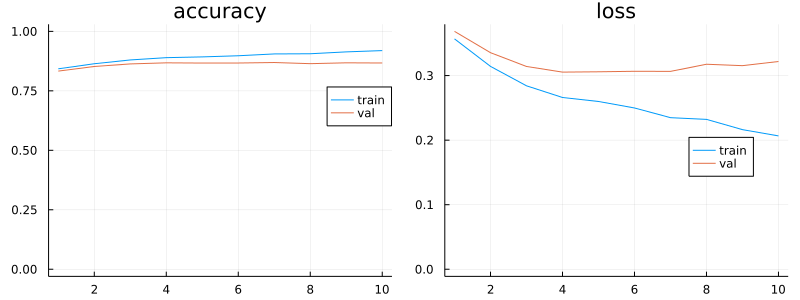

In [19]:
epochs = 1:length(history["train_acc"])
p1 = plot(epochs, history["train_acc"], label="train")
plot!(p1, epochs, history["val_acc"], label="val")
plot!(p1, ylims=[0, 1], title="accuracy", legend=(0.9, 0.7))

p2 = plot(epochs, history["train_loss"], label="train")
plot!(p2, epochs, history["val_loss"], label="val")
plot!(p2, title="loss", ylims=[0, Inf], legend=(0.8, 0.5))
plot(p1, p2, layout=grid(1, 2), size=(800, 300))

## Test data

In [20]:
logits = model(X_test)
@time accuracy(logits, y_test)

  0.575880 seconds (793.19 k allocations: 38.627 MiB, 99.98% compilation time)


0.86325

In [21]:
probs = σ.(logits)
y_pred = Int.(probs .> 0.5);

In [22]:
cm = confusion_matrix(vec(y_pred), vec(y_test), 0:1)

2×2 Matrix{Int64}:
 1751   249
  298  1702

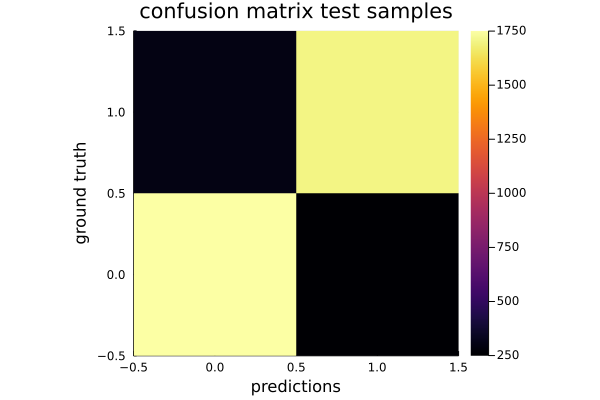

In [23]:
p = heatmap(0:1, 0:1, cm, xlabel="predictions", ylabel="ground truth", xlims=(-0.5,1.5), aspectratio=1, 
    title="confusion matrix test samples")
#savefig(p, "../outputs/confusion_matrix_regression.png")
p

In [24]:
classification_report(cm, 0:1)

              precision  recall  f1-score  support
           0       0.85    0.88      0.86     2000
           1       0.87    0.85      0.86     2000

weighted avg       0.86    0.86      0.86     4000

In [25]:
nshow = 3

for label in [0, 1]
    println("\ntrue label = $label")
    idxs = y_test .== label
    idxs_label = (1:size(y_test, 2))[vec(idxs)]
    idxs_wrong = idxs_label[y_pred[idxs] .!== label]
    println("#incorrect $(length(idxs_wrong))")
    for idx in sample(idxs_wrong, nshow, replace=false)
        println("$idx-$(y_test[idx])-$(y_pred[idx]) - ", documents_test[labels_test.!==3][idx])
    end
end


true label = 0
#incorrect 249
1042-0-1 - The device is nicely designed and quiet and seems to do a good job lowering allergen levels in our bedroom. However, it has one really silly design flaw - when plugged in it is always lit with an LED (red when off, blue when running). These lights are much dimmer than the night light they offer, but still much brighter than they should be for one's bedroom. I tape over the light, but it is impossible to block it out completely without also interfering with the air flow. Too bad!
804-0-1 - Wasn’t happy how it bent my hats & also left a line on the bill from the plastic
1165-0-1 - Big biggg large shoes as expected and loose fitting

true label = 1
#incorrect 298
2655-1-0 - I washed it and it lost much of its plush feel and color.
3004-1-0 - Look great, good quality. Needed to cut a notch in the drivers side front support bracket to get it to fit properly.
2816-1-0 - I don't know why I thought this kit would be laid out as in the picture. It isn't

## Probabilities for all labels

In [26]:
probs_all = σ.(model(indices_test));
y_pred_all = Int.(probs_all .> 0.5);

In [27]:
pos_max = argmax(probs_all)[2]
println(pos_max, " - ", labels_test[pos_max], " - ", y_pred_all[pos_max], " - ", 
        probs_all[pos_max], " - ", documents_test[pos_max])

pos_min = argmin(probs_all)[2]
println(pos_min, " - ", labels_test[pos_min], " - ", y_pred_all[pos_min], " - ", 
        probs_all[pos_min], " - ", documents_test[pos_min])

4870 - 5 - 1 - 0.9995252 - Great bang for the buck!
623 - 1 - 0 - 0.0013561209 - Shines dimly. broke on next day! Awful, terrible quality. Price is higher than any other. Do not waste time and money on this!


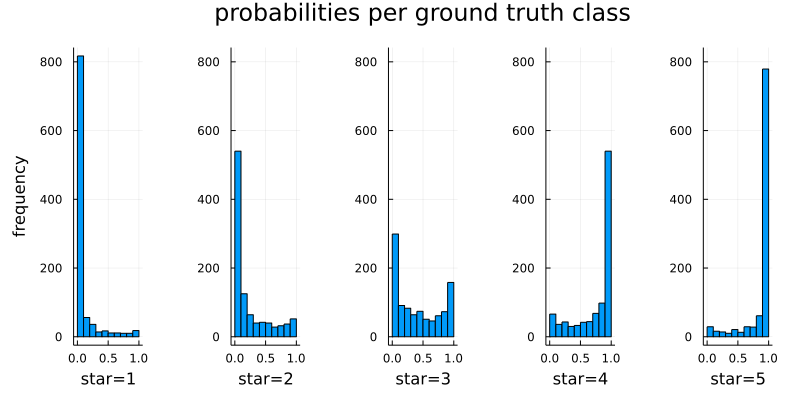

In [28]:
p = plot()
canvases = []
for star in 1:5
    idxs = labels_test .== star
    c = histogram(probs_all[idxs], label="", xticks=([0.00, 0.50, 1.00]), xlabel="star=$star", nbins=12)
    push!(canvases, c)
end
plot!(canvases[1], ylabel="frequency")
p = plot(canvases..., layout=(1, 5), link=:y, size=(800, 400), plot_title="probabilities per ground truth class",
    margin=5Plots.mm)
#savefig(p, "../outputs/probabilities_ground_truth.png")
p

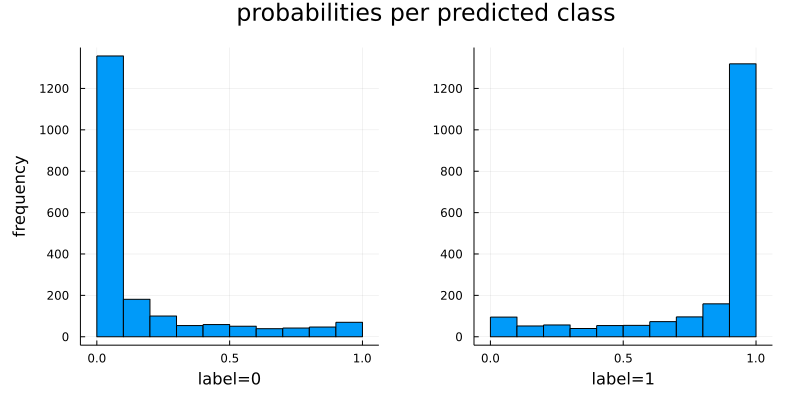

In [29]:
p = plot()
canvases = []
for label in 0:1
    idxs = y_test .== label
    c = histogram(probs[idxs], label="", xticks=([0.00, 0.50, 1.00]), xlabel="label=$label", nbins=12)
    push!(canvases, c)
end
plot!(canvases[1], ylabel="frequency")
p = plot(canvases..., layout=(1, 2), link=:y, size=(800, 400), plot_title="probabilities per predicted class",
    margin=5Plots.mm)
#savefig(p, "../outputs/probabilities_ground_truth.png")
p

In [30]:
nshow = 3

label = 5
println("true label = $label")
idxs = labels_test .== label
idxs_label = (1:length(labels_test))[vec(idxs)]
idxs_wrong = idxs_label[probs_all[idxs] .<= 0.1]
println("#incorrect $(length(idxs_wrong))")
for idx in sample(idxs_wrong, nshow, replace=false)
    println("$idx-$(labels_test[idx])-$(probs_all[idx]) - ", documents_test[idx])
end

println("")

label = 1
println("true label = $label")
idxs = labels_test .== label
idxs_label = (1:length(labels_test))[vec(idxs)]
idxs_wrong = idxs_label[probs_all[idxs] .>= 0.9]
println("#incorrect $(length(idxs_wrong))")
for idx in sample(idxs_wrong, nshow, replace=false)
    println("$idx-$(labels_test[idx])-$(probs_all[idx]) - ", documents_test[idx])
end

true label = 5
#incorrect 29
4144-5-0.025477137 - i've had this device for a year and 4 months. it is simple and straight forward to use. i bought this because the drivers are stable,
4544-5-0.040040422 - Would Not Use any other Cologne
4973-5-0.084961616 - Love the look of these! They look like real tiles! They really aren't too bad to install. Hardest part was peeling the backing off, but found it worked better to peel the tile off of the backing... if that makes sense!

true label = 1
#incorrect 18
470-1-0.9068197 - We have another puzzle like this we love and were excited to add to ours but this is just circles with the smaller shapes painted on. Not what is looks like, no challenge
524-1-0.9171746 - Smells like Fish, tastes like Fish. Yuck
756-1-0.97320235 - I know this tracker is several years old and the technology has improved a lot since then, so I was really not expecting much. I just needed a simple step tracker that clips onto my clothing and syncs with my phone, and the pr

## Single samples

In [31]:
idx = 4700  

d = documents_test[idx]
println(labels_test[idx])
println(d)
tokens = preprocess(d, tokenizer, max_length=50)
println(join(tokens, "|"))
x = indexer(tokens)
x = vcat(x, ones(Int, 50 - length(x)))
println(join(x, "|"))

5
This makes almost the whole series. Roman Nights will be the last one. Loved them all. Alaskan Nights was awesome. Met my expectations , hot SEAL hero, beautiful & feisty woman. Filled with intrigue, steamy romance & nail biting ending. Have read two other books of yours. Am looking forward to more.
⋅this|⋅makes|⋅almost|⋅the|⋅whole|⋅series|⋅rom|##an|⋅nights|⋅will|⋅be|⋅the|⋅last|⋅one|⋅loved|⋅them|⋅all|⋅al|##ask|##an|⋅nights|⋅was|⋅awesome|⋅met|⋅my|⋅expectations|⋅hot|⋅seal|⋅hero|⋅beautiful|⋅fe|##ist|##y|⋅woman|⋅filled|⋅with|⋅intrig|##ue|⋅stea|##my|⋅romance|⋅nail|⋅bit|##ing|⋅ending|⋅have|⋅read|⋅two|⋅other|⋅books
8|242|306|2|475|633|5068|985|2849|44|28|2|167|27|235|32|37|1647|6812|985|2849|14|476|2962|11|1759|403|831|3469|347|2966|1578|269|1998|1521|17|4949|3152|4805|3813|2152|1626|137|124|1537|18|175|106|79|553


In [32]:
model.embed(x)

32×50 Matrix{Float32}:
 -1.54896    -2.00106    -1.98534    …  -0.338689   -0.160848   -3.11561
  0.0805355   0.45128    -2.11784        0.70048    -0.525266    0.65913
 -1.30101    -0.974185    1.38631        0.069824   -0.245127   -0.684106
  0.190581   -0.301638   -2.22475        0.26494     0.494853   -1.68516
  0.180507    0.159264    1.11615       -0.869097   -1.2408     -0.0683391
 -0.62507    -1.20952     0.258889   …   0.0107145  -0.120839   -0.812466
  0.496186    0.427093   -0.492511      -0.201567   -0.624775   -0.501922
  0.789521   -1.69039    -0.908622      -1.25877     0.18119    -0.571936
 -0.982163    0.644753   -1.78569       -1.09077    -0.417266    0.205673
 -0.627659   -0.0835341  -0.0835094     -0.407022   -0.219456    2.86937
 -0.859158    0.178679   -1.31079    …  -0.0266605   2.02772     2.5937
 -1.15892    -1.48556    -1.17854        1.19134     0.15329    -0.418811
  1.28861    -0.0699925   0.549659       1.49717    -0.82557    -1.81994
  ⋮                  

In [33]:
σ.(model(x))

1×1 Matrix{Float32}:
 0.9980896